In [23]:
#Imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import pkg_resources
import types
import time
import platform

%matplotlib inline

In [24]:
#Import and explore raw data
data=pd.read_csv('data.csv')
data.shape

(16272, 4)

In [25]:
#Separate data from target and remove proj_id and file_id columns
clean_data=data.loc[:,'file_body'].astype(str)
clean_target=data.loc[:,'language']

#Shuffle data and split it into train and test sets
#Use defined random_state to be able to compare scores for different params
X_train, X_test, y_train, y_test = train_test_split(clean_data, clean_target, random_state=87, stratify=clean_target)

In [26]:
# See what unique languages are used in this project
df1=pd.DataFrame(X_train).join(y_train)
df1.iloc[1]

un=df1.groupby('language').nunique()
x=un.loc[:,'file_body']
un
#print(un[un.loc[:,'language']==])

,file_body,language
language,,
C,809,1
C++,659,1
Fortran,558,1
Go,748,1
Haskell,1000,1
Java,739,1
JavaScript,819,1
Julia,478,1
Kotlin,482,1


In [27]:

un2=data.groupby('language').nunique()
y=un2.div(un2,axis=1)
y=un.loc[:,'file_body'].divide(un2.loc[:,'file_body'])
y
#np.ndarray(un.loc[:,'file_body'])/np.ndarray(un2.loc[:,'file_body'])
#un.loc[:,'file_body']

language
C              0.750464
C++            0.749716
Fortran        0.751009
Go             0.750251
Haskell        0.750188
Java           0.750254
JavaScript     0.756233
Julia          0.752756
Kotlin         0.749611
MATLAB         0.750462
Mathematica    0.751896
PHP            0.750524
Perl           0.750661
Python         0.750863
R              0.749169
Ruby           0.750000
Rust           0.750600
Scala          0.749687
Swift          0.751861
Name: file_body, dtype: float64

In [28]:
#Extract features from 'file_body' column. For this 
#I use CountVectoriser and later transform counts into frequencies with TfidfTransformer
#This can be done with one method: TfidfVectorizer
tic=time.time()
count_vect = CountVectorizer(ngram_range=(3,5),analyzer='char')
tfidf_transformer = TfidfTransformer(use_idf=True)
tfidf_vect = TfidfVectorizer(ngram_range=(3,5),analyzer='char',use_idf=True)

#Fit and transform train set
X_train_counts = count_vect.fit_transform(X_train)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

tfidf_vect=tfidf_vect.fit(X_train)

#tfidf_vect=tfidf_vect.fit(clean_data)
#Just transform test set
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
toc=time.time()

print(f'{(toc-tic):.4f} s elapsed')

39.5439 s elapsed


In [29]:
#Train the model using training set
tic=time.time()
clf = SGDClassifier(loss='hinge', penalty='l2',\
alpha=5e-4,max_iter=100, tol=None,n_jobs=-1,shuffle=True)
clf.fit(X_train_tfidf, y_train)

toc=time.time()
print(f'{(toc-tic):.4f} s elapsed')

54.3293 s elapsed


In [30]:
#Check the precission of the model on train set and then on test set
tic=time.time()
predicted_train_score = clf.score(X_train_tfidf, y_train)
predicted_train=clf.predict(X_train_tfidf)

predicted_test_score = clf.score(X_test_tfidf, y_test)
predicted_test=clf.predict(X_test_tfidf)

toc=time.time()
print(f'{(toc-tic):.4f} s elapsed')
print(f'Train score: {predicted_train_score:.6f} \nTest score: {predicted_test_score:.6f}')


1.7484 s elapsed
Train score: 0.988283 
Test score: 0.934366


In [31]:
tfidf_vect=tfidf_vect.fit(clean_data)
clf.fit(tfidf_vect.transform(X_train), y_train)
print(clf.score(tfidf_vect.transform(X_test), y_test))

0.9331366764995084


In [10]:
#See the classification report for the test set
cr=classification_report(y_test, predicted_test,output_dict=False)
print(cr)

              precision    recall  f1-score   support

           C       0.90      0.93      0.91       254
         C++       0.97      0.88      0.92       231
     Fortran       0.95      0.97      0.96       188
          Go       0.96      0.98      0.97       255
     Haskell       0.92      0.97      0.94       310
        Java       0.95      0.93      0.94       241
  JavaScript       0.91      0.91      0.91       280
       Julia       0.95      0.84      0.89       163
      Kotlin       0.97      0.99      0.98       148
      MATLAB       0.89      0.85      0.87       138
 Mathematica       0.88      0.94      0.91       232
         PHP       0.95      0.89      0.92       119
        Perl       0.94      0.97      0.96       303
      Python       0.90      0.97      0.93       356
           R       0.96      0.89      0.93       169
        Ruby       0.93      0.98      0.96       278
        Rust       0.99      0.98      0.99       102
       Scala       0.95    

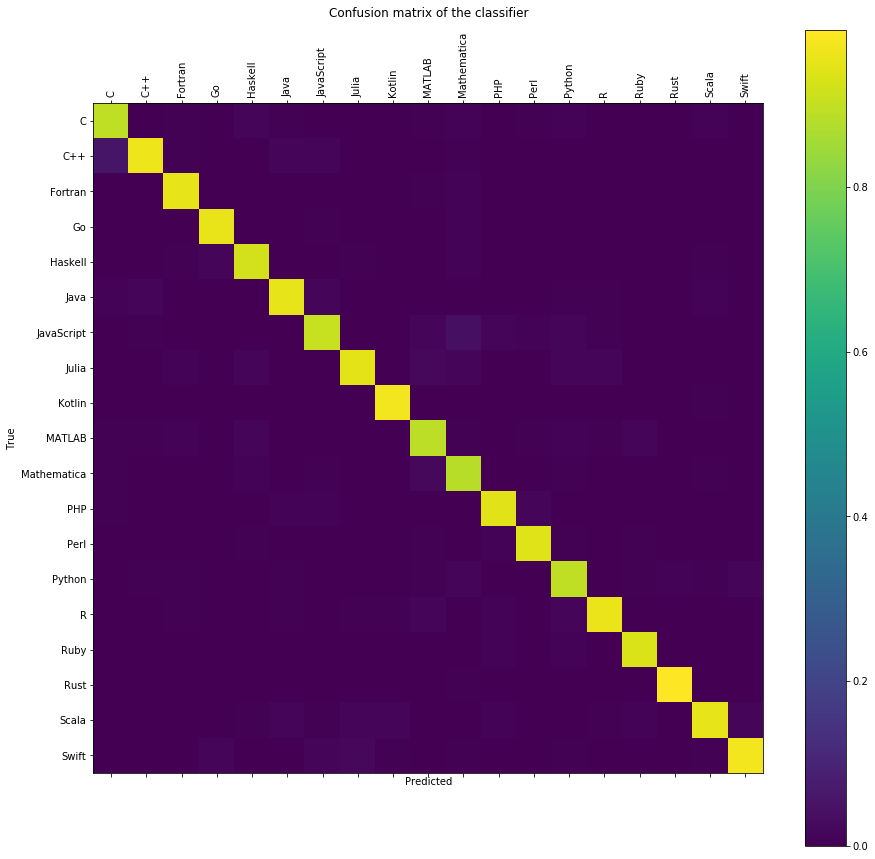

In [11]:
#Visualise confusion matrix for test set
labels = clf.classes_
cm = confusion_matrix(y_test, predicted_test, labels)
#Normalise the confusion matrix
ncm = cm/cm.astype(np.float).sum(axis=0)
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
cax = ax.matshow(ncm)
plt.title('Confusion matrix of the classifier',y=1.12)
fig.colorbar(cax)
plt.xticks(rotation='vertical')
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Let's build a pipeline for grid search with cross-validation
text_clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(3,5),analyzer='char')),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',\
    alpha=1e-4, random_state=42, max_iter=100, tol=None, n_jobs=-1)),
])

### One can preform grid search with cross-validation to find best parameters. Below is the code I used for doing it
### As it takes some time to run the grid seach CV I marked the cell above and this one as Markdown
parameters = {
    'vect__ngram_range': [(1,10),(2,9),(3,8)],\
    'clf__alpha': (1e-2,0.5e-2,1e-3,0.5e-3,1e-4)
}

gs_clf = GridSearchCV(text_clf, parameters, cv=4, iid=False, n_jobs=-1,verbose=50)

#One can reduce the data to speed things up
gs_clf = gs_clf.fit(X_train[:1000], y_train[:1000])
gs_clf.best_score_  
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

## Just for fun, insert any text below and check if the model works correctly :)

In [12]:
text=['''

# Insert text here
      ''']

text_tfidf=tfidf_vect.transform(text)
print(clf.predict(text_tfidf))

['Haskell']


In [13]:
#Save requirements.txt file with only packages used in this notebook (instead of the list of all
#produced by pip freeze)
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        poorly_named_packages = {
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))
        
f = open('requirements.txt','w')
f.write("{}=={}".format('Python',platform.python_version()))
f.write('\n')
print("{}=={}".format('Python',platform.python_version()))
for r in requirements:
    f.write("{}=={}".format(*r))
    f.write('\n')
    print("{}=={}".format(*r))
f.close()

Python==3.6.6
scikit-learn==0.20.0
pandas==0.23.4
numpy==1.15.4
matplotlib==3.0.2


## Remarks
The model score is quite high, with test set score a bit lower than train score, which is expected.
The modeling was done without tweaking the data. What can be done to improve the model is, for example, to remove comments from file_body coulmn, leaving just the code.

### Resources used:
Official scikit-learn documentation


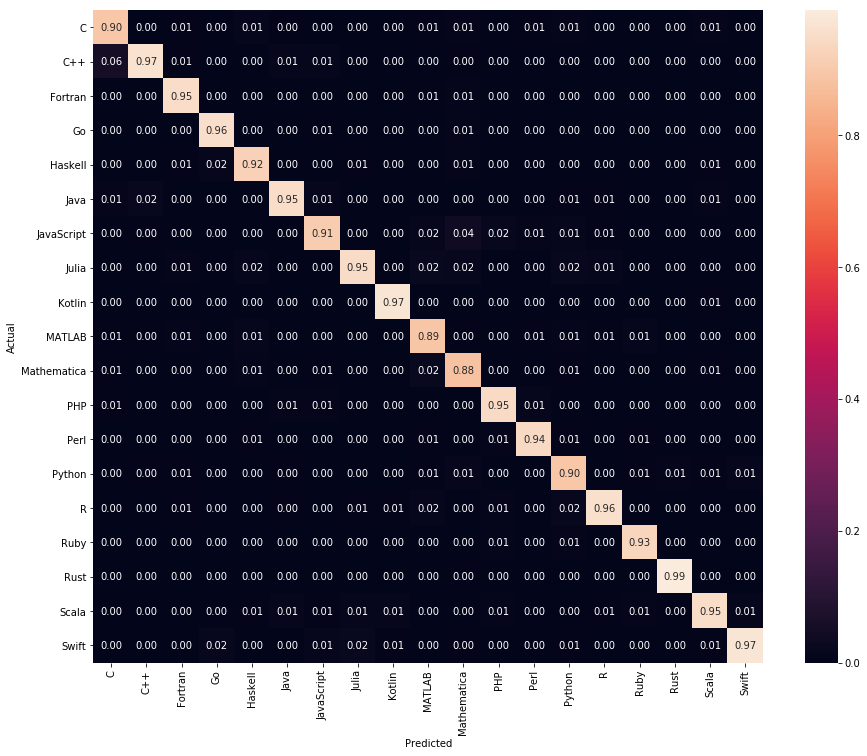

In [14]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(ncm, annot=True, fmt='.2f',
            xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()